In [31]:
from utilities import *

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/testing-framework/utilities.py:50: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


Text(0.5, 1.0, 'r = 0.2, eta = 1.4 Pdf')

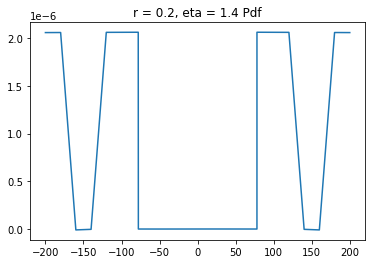

In [32]:
xs, prior_vals_2_14 = compute_prior_pdf(r = 0.2, eta= 1.4, n_samples = 10000)
plt.plot(xs, prior_vals_2_14)
plt.title("r = 0.2, eta = 1.4 Pdf")

In [33]:
np.trapz(prior_vals_2_14, xs) 

0.00033716685697652443

Text(0.5, 1.0, 'r = 0.2, eta = 1.4 Pdf Zoomed In')

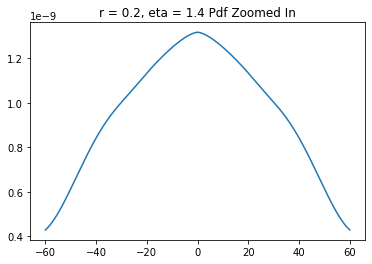

In [34]:
idx = np.logical_and(xs > - 60, xs < 60)
plt.plot(xs[idx], prior_vals_2_14[idx])
plt.title("r = 0.2, eta = 1.4 Pdf Zoomed In")

In [35]:
np.trapz(xs[idx], prior_vals_2_14[idx]) 

-6.290951043886386e-08

/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/testing-framework/utilities.py:92: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


Text(0.5, 1.0, 'r = 0.2, eta = 1.4 Cdf')

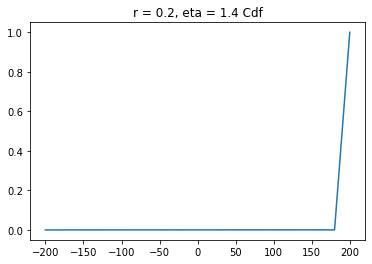

In [36]:
prior_cdf_2_14 = compute_prior_cdf(r = 0.2, eta= 1.4, n_samples = 10000)
plt.plot(xs, prior_cdf_2_14(xs))
plt.title("r = 0.2, eta = 1.4 Cdf")

Text(0.5, 1.0, 'r = 0.2, eta = 1.4 cdf')

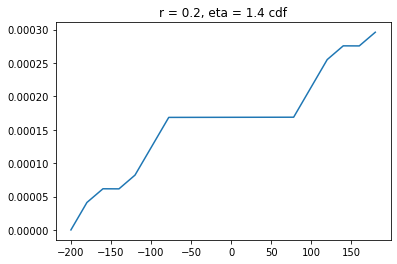

In [37]:
plt.plot(xs[:-1], prior_cdf_2_14(xs[:-1]))
plt.title("r = 0.2, eta = 1.4 cdf")

Text(0.5, 1.0, 'r = 0.2, eta = 1.6 Pdf')

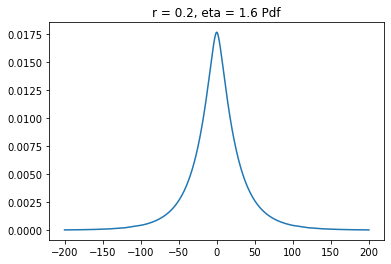

In [61]:
xs, prior_vals_2_16 = compute_prior_pdf(r = 0.6, eta= 3.2, n_samples = 10000)
plt.plot(xs, prior_vals_2_16)
plt.title("r = 0.2, eta = 1.6 Pdf")

In [62]:
np.trapz(prior_vals_2_16, xs) 

0.9992595199977364

Text(0.5, 1.0, 'r = 0.2, eta = 1.6 Cdf')

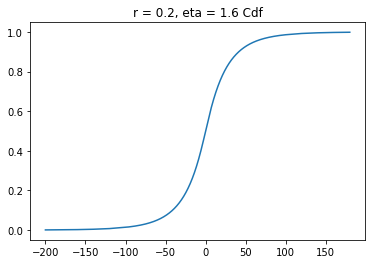

In [60]:
prior_cdf_2_16 = compute_prior_cdf(r = 0.6, eta= 3.2, n_samples = 10000)
plt.plot(xs[:-1], prior_cdf_2_16(xs[:-1]))
plt.title("r = 0.2, eta = 1.6 Cdf")

Text(0.5, 1.0, 'r = 0.4, eta = 3 Cdf')

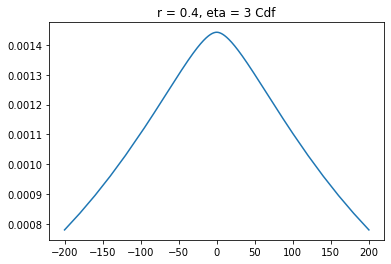

In [41]:
xs, prior_vals_4_3 = compute_prior_pdf(r = 0.4, eta= 3, n_samples = 10000)
plt.plot(xs, prior_vals_4_3)
plt.title("r = 0.4, eta = 3 Cdf")

In [42]:
np.trapz(prior_vals_4_3, xs) 

0.44520558043876945

Text(0.5, 1.0, 'r = 0.4, eta = 3 Cdf')

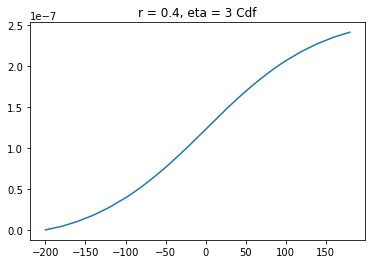

In [43]:
prior_cdf_4_3 = compute_prior_cdf(r = 0.4, eta= 3, n_samples = 10000)
plt.plot(xs[:-1], prior_cdf_2_16(xs[:-1]))
plt.title("r = 0.4, eta = 3 Cdf")

# NEW SOLUTION

In [44]:
import matlab.engine 
eng = matlab.engine.start_matlab()

In [45]:
def compute_prior_pdf_new(r, eta, n_samples = 10000, tail_bound = 0.05, n_tail = 5, scale = 1, scipy_int=True):

    '''
    Returns support and pdf for prior distribution
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_pdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_pdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby < 120:
        n_tail = 0
        print("No Tail")
        
    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    # Loop over xs
    for j, x in enumerate(xs):

        # Define integrands
        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        # Integrate 
        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = eng.testIntegrals(float(r), float(eta), float(x), nargout=1)
    return xs, prior_pdf

In [46]:
def compute_prior_cdf_new(r, eta, n_samples = 1000, tail_bound = 0.05, n_tail = 5, scale = 1, scipy_int=True):

    '''
    Returns PPoly-type function that approximates the prior CDF of the signal x
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_cdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_cdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby < 120:
        n_tail = 0
        print("No Tail")
    
   
    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    # Loop over xs
    for j, x in enumerate(xs):

        # Define integrands
        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        # Integrate 
        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = prior_pdf[j] = eng.testIntegrals(float(r), float(eta), x, nargout=1)

    prior_cdf = np.zeros_like(prior_pdf)
    for i in range(len(xs) - 1):
           
        prior_cdf[i] = np.trapz(prior_pdf[:i+1], xs[:i+1])
    
    prior_cdf = np.append(prior_cdf[:-1], 1)
    poly = interpolate.CubicSpline(x = xs, y = prior_cdf)
    return poly

In [47]:
x = 100
r = 1.2
eta = 1.2
beta = (eta + 1.5)/r 
scale = 1
def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

def gen_gamma_density(theta):
    return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

def integrand(theta):
    return gauss_density(theta) * gen_gamma_density(theta)

# Integrate 
integrate.quad(integrand, 0, np.inf, limit = 5000)[0]

1.8713946977040587e-20

Text(0.5, 1.0, 'r = 0.2, eta = 1.4 Pdf Matlab')

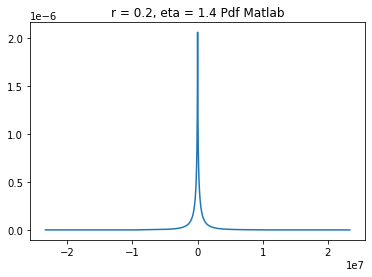

In [48]:
xs_2_14_new, prior_vals_2_14_new = compute_prior_pdf_new(r = 0.2, eta= 1.4, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)
plt.plot(xs_2_14_new, prior_vals_2_14_new)
plt.title("r = 0.2, eta = 1.4 Pdf Matlab")

In [71]:
np.trapz(prior_vals_2_14_new, xs_2_14_new) 

0.9921237228651889

In [72]:
integrate.simps(prior_vals_2_14_new, xs_2_14_new)

0.98951202551069

Text(0.5, 1.0, 'r = 0.2, eta = 1.4 Cdf Matlab')

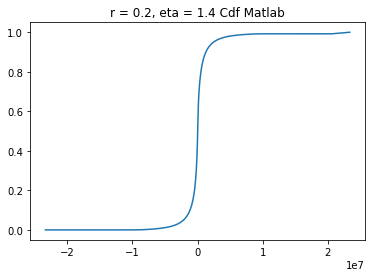

In [50]:
prior_cdf_2_14_new = compute_prior_cdf_new(r = 0.2, eta= 1.4, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)
plt.plot(xs_2_14_new, prior_cdf_2_14_new(xs_2_14_new))
plt.title("r = 0.2, eta = 1.4 Cdf Matlab")

Text(0.5, 1.0, 'r = 0.2, eta = 1.6 Pdf Matlab')

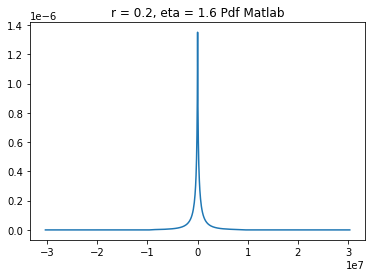

In [51]:
xs_2_16_new, prior_vals_2_16_new = compute_prior_pdf_new(r = 0.2, eta= 1.6, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)
plt.plot(xs_2_16_new, prior_vals_2_16_new)
plt.title("r = 0.2, eta = 1.6 Pdf Matlab")

In [52]:
np.trapz(prior_vals_2_16_new, xs_2_16_new) 

0.9842794085452775

Text(0.5, 1.0, 'r = 0.2, eta = 1.6 Cdf Matlab')

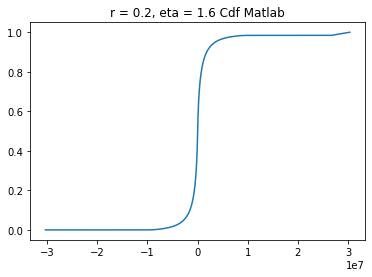

In [53]:
prior_cdf_2_16_new = compute_prior_cdf_new(r = 0.2, eta= 1.6, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)
plt.plot(xs_2_16_new, prior_cdf_2_16_new(xs_2_16_new))
plt.title("r = 0.2, eta = 1.6 Cdf Matlab")

Text(0.5, 1.0, 'r = 0.4, eta = 3 Pdf Matlab')

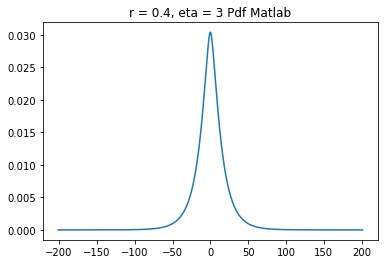

In [64]:
xs_4_3_new, prior_vals_4_3_new = compute_prior_pdf_new(r = 0.7, eta= 3.6, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)
plt.plot(xs_4_3_new, prior_vals_4_3_new)
plt.title("r = 0.4, eta = 3 Pdf Matlab")

In [65]:
np.trapz(prior_vals_4_3_new, xs_4_3_new) 

0.9999911156603145

Text(0.5, 1.0, 'r = 0.4, eta = 3 Cdf Matlab')

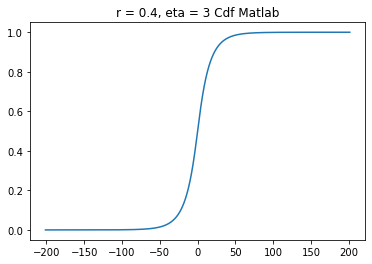

In [66]:
prior_cdf_4_3_new = compute_prior_cdf_new(r = 0.7, eta= 3.6, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=False)
plt.plot(xs_4_3_new, prior_cdf_4_3_new(xs_4_3_new))
plt.title("r = 0.4, eta = 3 Cdf Matlab")

Text(0.5, 1.0, 'r = 0.4, eta = 3 Pdf SciPy')

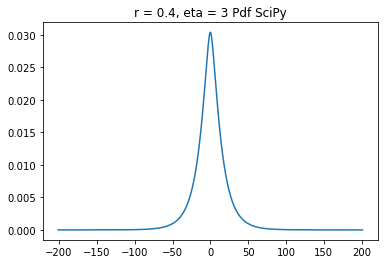

In [67]:
xs_4_3_new, prior_vals_4_3_new_sp = compute_prior_pdf_new(r = 0.7, eta= 3.6, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=True)
plt.plot(xs_4_3_new, prior_vals_4_3_new_sp)
plt.title("r = 0.4, eta = 3 Pdf SciPy")

In [68]:
np.trapz(prior_vals_4_3_new_sp, xs_4_3_new) 

0.9999911156520126

Text(0.5, 1.0, "Text(0.5, 1.0, 'r = 0.4, eta = 3 Pdf SciPy')")

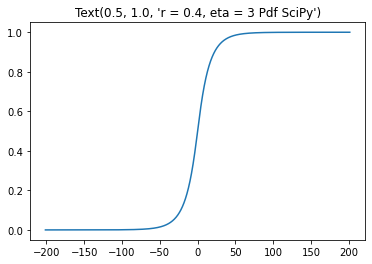

In [69]:
prior_cdf_4_3_new_sp = compute_prior_cdf_new(r = 0.7, eta= 3.6, n_samples = 10000, n_tail = 100, tail_bound = 0.01, scipy_int=True)
plt.plot(xs_4_3_new, prior_cdf_4_3_new_sp(xs_4_3_new))
plt.title(plt.title("r = 0.4, eta = 3 Pdf SciPy"))